In [81]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from tqdm import tqdm_notebook as tqdm

root = './DIP_2019_A1/'

In [219]:
def read_img(name, gray=False):
    fg = cv2.imread(name)
    fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
    if gray: fg = cv2.cvtColor(fg, cv2.COLOR_RGB2GRAY)
    return fg


In [186]:
def plot(imgs, gray=False, titles=[], FigSize=(20,8)):
    fig = plt.figure(figsize=FigSize)
    if len(imgs)>=3: num_plots = (np.ceil(len(imgs)/3.0),3)
    else: num_plots = (np.ceil(len(imgs)/3.0),len(imgs))
        
    for i in range(len(imgs)):
        ax = fig.add_subplot(*num_plots, i+1)
        if not gray: ax.imshow(imgs[i])
        else: ax.imshow(imgs[i], cmap='gray', vmin=np.min(imgs[i]), vmax=np.max(imgs[i]))
        ax.axis("off")            
        if i<len(titles): ax.title.set_text(titles[i])


In [280]:
def plot_og_scale(imgs, gray=False, titles=[], FigSize=(20,8)):
    fig = plt.figure(figsize=FigSize)
    if len(imgs)>=3: num_plots = (np.ceil(len(imgs)/3.0),3)
    else: num_plots = (np.ceil(len(imgs)/3.0),len(imgs))
        
    for i in range(len(imgs)):
        ax = fig.add_subplot(*num_plots, i+1)
        if not gray: ax.imshow(imgs[i])
        else: ax.imshow(imgs[i], cmap='gray', vmin=0, vmax=255)
        ax.axis("off")            
        if i<len(titles): ax.title.set_text(titles[i])


---
<div width="100%" align="center"> <h1>Q2</h1></div>

---

## 1. Most frequent color

In [ ]:
fg = cv2.imread(root+'fg.jpg')
fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
bg = cv2.imread(root+'bg.jpg')
bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)

fg.dtype

In [166]:
def get_most_freq_color(img):
    I = np.array(img, dtype=np.float64)
    
    counts = np.zeros((256,256,256))
    
    ma = -1
    mac = []
    for i in tqdm(range(I.shape[0])):
        for j in range(I.shape[1]):
            r = int(I[i,j,0])
            g = int(I[i,j,1])
            b = int(I[i,j,2])
            counts[r,g,b] += 1
            
            if counts[r,g,b]>ma:
                ma = counts[r,g,b]
                mac = np.array([[r],[g],[b]])
    return mac

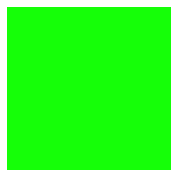

In [332]:
mac = get_most_freq_color(fg).reshape((3))
a = np.zeros((3,3,3))
for i in range(3):
    for j in range(3):
        a[i,j,:] = mac

plot([np.array(a, dtype=np.uint8)], FigSize=(3,3))

## 2. Merge Images
1. Find the most frequently occuring color in fg. This will be the background(assume).
2. Make a mask of 1 and 0. 1 in the pixels where we have the background. 0 others.  
        a. Background is determined by finding the **cosine similarity** between each pixel of the image (taken as a 
           [R,G,B] vector) and a [R,G,B] vector of the background color.
        b. If the angle between the vectors is more than 18 deg, we say that the pixel is fg, else bg.
3. Multiply the mask with the bg and inverse of the mask with fg and add to get the final img

In [348]:
def mergeImage(fg, bg, epsilon=0.8):
    fg = fg.copy()
    bg = bg.copy()
    
    mac = get_most_freq_color(fg)
    
    fg_corrected = np.array(fg,dtype=np.float64) + 0.00001
    x = np.sum(fg_corrected*mac.reshape(1,1,3), axis=2)
    x = x / np.sqrt(np.sum(fg_corrected*fg_corrected, axis=2))
    x = x / np.sqrt(np.sum(mac.reshape(1,1,3)*mac.reshape(1,1,3), axis=2))
    
    t = (x > epsilon) # t is the matrix telling us which squares to remove from fg(if true, then remove)
    t = t.reshape((t.shape[0], t.shape[1], 1))
    
    fg = np.array(~t, dtype=np.uint8)*fg + np.array(t, dtype=np.uint8)*bg
    t = t.reshape((720,1280))
    
    a = np.zeros((3,3,3))
    for i in range(3):
        for j in range(3):
            a[i,j,:] = mac.reshape(3)
    a = np.array(a, dtype=np.uint8)
    plot([t, a], gray=True, FigSize=(8,8), titles=["FG MASK", "BG COLOR"])
    return fg

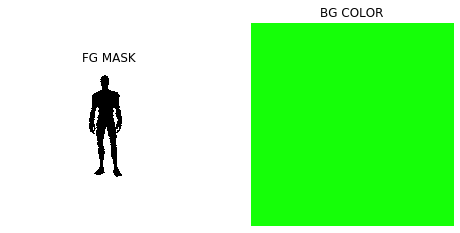

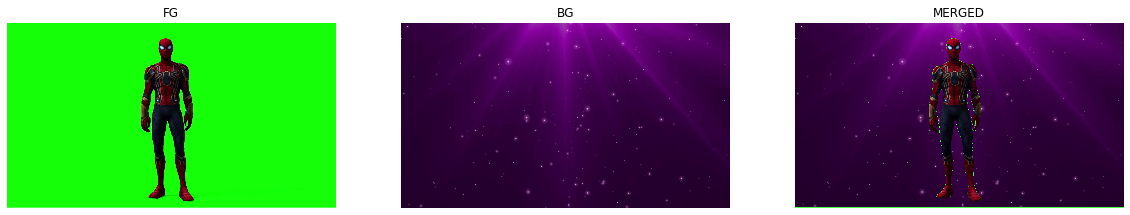

In [349]:
op = mergeImage(fg,bg,epsilon=0.95)

plot([fg,bg,op], FigSize=(20,20), titles=["FG", "BG", "MERGED"])

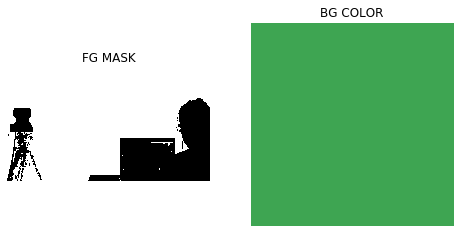

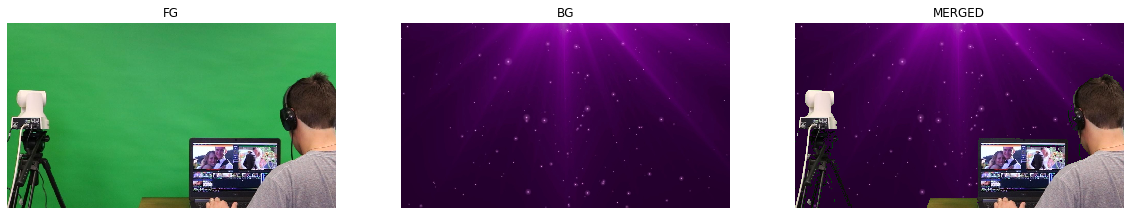

In [351]:
fg1 = read_img('./input/fg_complex.jpg')
fg1 = fg1[100:820,100:1380,:]
op = mergeImage(fg1,bg,epsilon=0.95)
plot([fg1,bg,op], FigSize=(20,20),  titles=["FG", "BG", "MERGED"])

---
<div width="100%" align="center"> <h1>Q2</h1></div>

---

## 1. Line Contrast Stretching

In [12]:
def linContrastStretching(img, a, b):
    '''
    min maps to a
    max maps to b
    basically a line between (min,a) and (max,b)
    s = (b-a)/(max-min) (r-min) + a
    '''
    
    img = np.array(img, dtype=np.float64)
    m = np.min(img)
    M = np.max(img)
    
    img_dash = np.round((b-a)*(img-m)/(M-m) + a, decimals=0)
    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(121)
    ax.imshow(np.array(img, dtype=np.uint8), cmap='gray', vmin=0, vmax=255)
    ax.axis("off")

    ax2 = fig.add_subplot(122)
    disp = ax2.imshow(np.array(img_dash, dtype=np.uint8), cmap='gray', vmin=0, vmax=255)
    ax2.axis("off")
    
    
    fig.colorbar(disp, ax=ax2, fraction=0.025)
    return img_dash

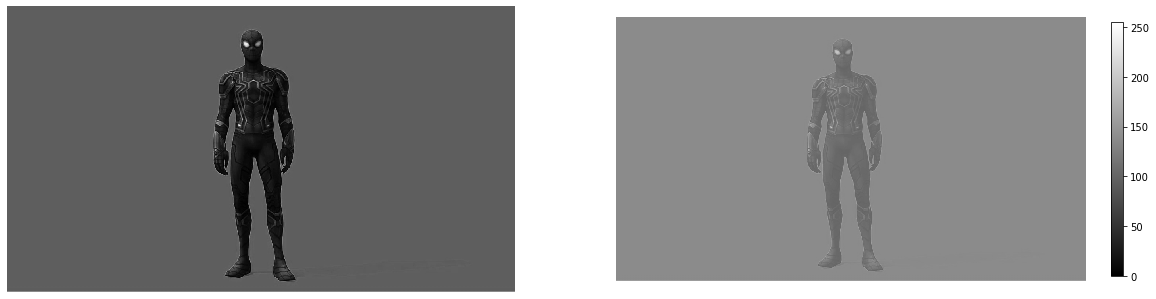

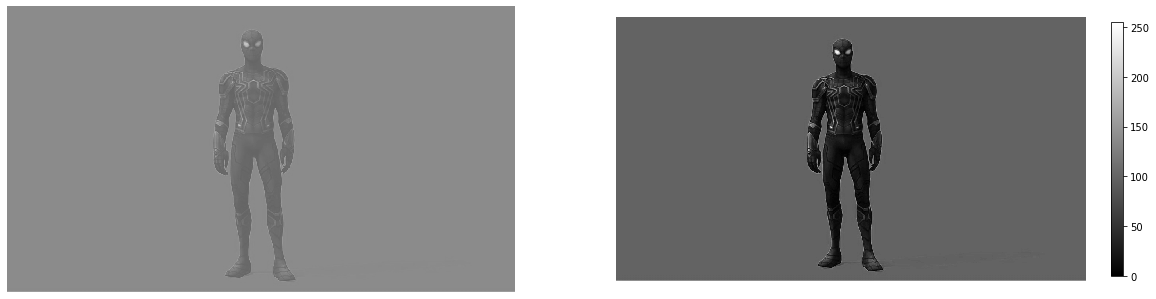

In [14]:
a = linContrastStretching(np.mean(fg, axis=2), 100,200)
a = linContrastStretching(a, 0,255)

---
<div width="100%" align="center"> <h1>Q3</h1></div>

---

## 1.

In [274]:
img = read_img(root+'quantize.jpg')

In [275]:
def BitQuantizeImage(im, k, plot=True):
    im = np.array(im, dtype=np.float64)
    im_dash = np.floor(im/np.power(2,8-k))*np.power(2,8-k)
    im_dash = np.array(im_dash, dtype=np.uint8)
    
    if plot:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(121)
        ax.imshow(np.array(im, dtype=np.uint8))
        ax.axis("off")
        ax.title.set_text("Original")

        ax = fig.add_subplot(122)
        ax.imshow(im_dash)
        ax.axis("off")
        ax.title.set_text("{} bit quantised".format(k))
    
    return im_dash
    

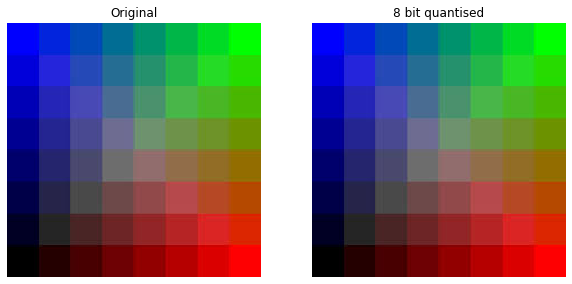

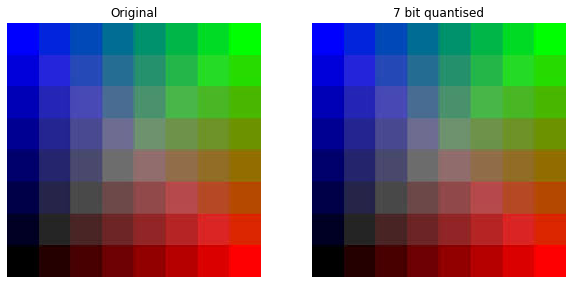

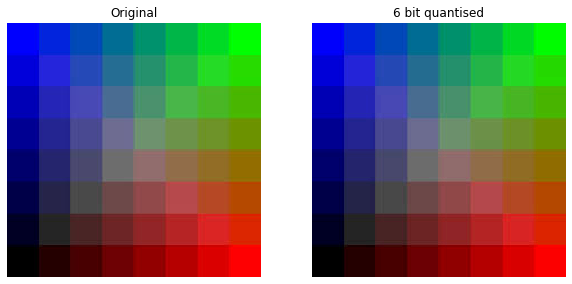

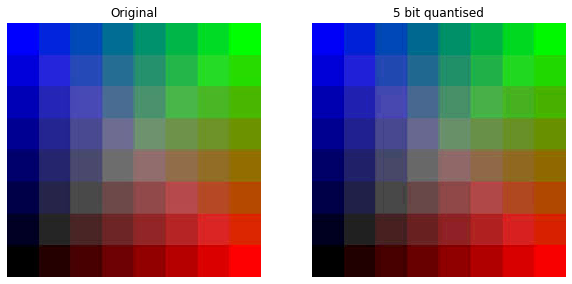

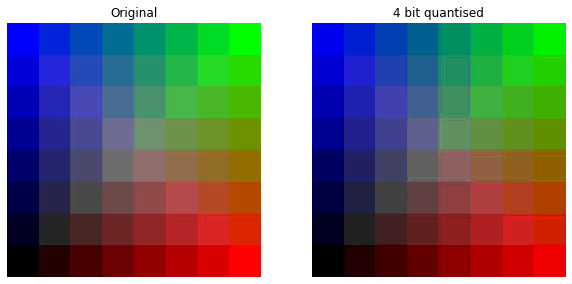

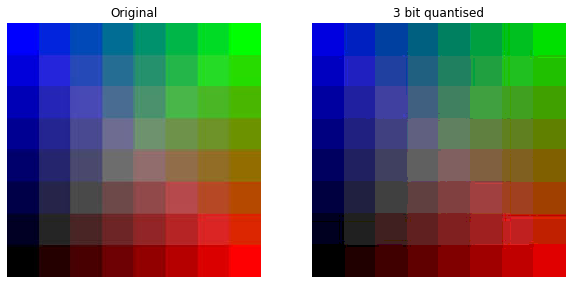

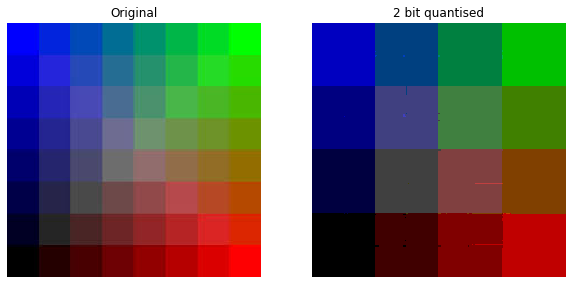

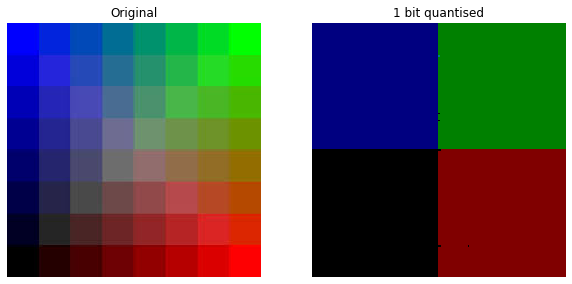

In [276]:
# a = interact(BitQuantizeImage, im=fixed(img), k=(1,8,1))

a = BitQuantizeImage(img, 8)
a = BitQuantizeImage(img, 7)
a = BitQuantizeImage(img, 6)
a = BitQuantizeImage(img, 5)
a = BitQuantizeImage(img, 4)
a = BitQuantizeImage(img, 3)
a = BitQuantizeImage(img, 2)
a = BitQuantizeImage(img, 1)



## 2. Bit Plane Extraction

In [243]:
img = read_img(root+'cameraman.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [244]:
def bitPlaneExtraction(img, Plot=True):
    imgs = [img.copy()]
    
    p = 1
    for i in range(8):
        p = np.power(2,i)
        timg = img & p
        timg = np.array(timg>0, dtype=np.uint8)
        imgs.append(timg.copy())
    
    if Plot: plot(imgs, gray=True, FigSize=(10,10), titles=["Original", *("{} bitplane".format(i+1) for i in range(8))])
    return imgs

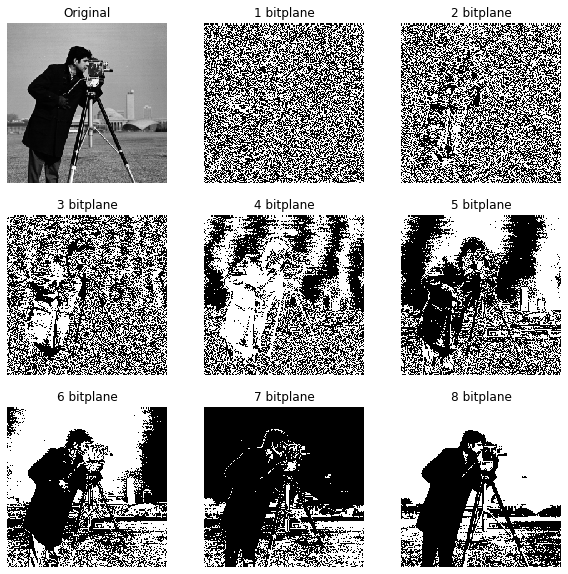

In [245]:
a = bitPlaneExtraction(img)

## 3. Lena Image Operations

In [246]:
img = read_img(root+'lena.jpg', gray=True)
img1 = read_img(root+'lena1.jpg', gray=True)
img2 = read_img(root+'lena2.jpg', gray=True)
img3 = read_img(root+'lena3.jpg', gray=True)

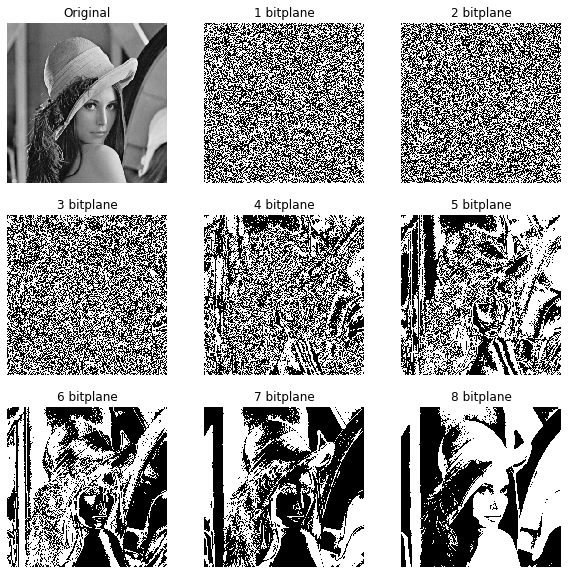

In [247]:
a = bitPlaneExtraction(img)

### a) LENA1
The operation is ***extracting the 5th bit plane***

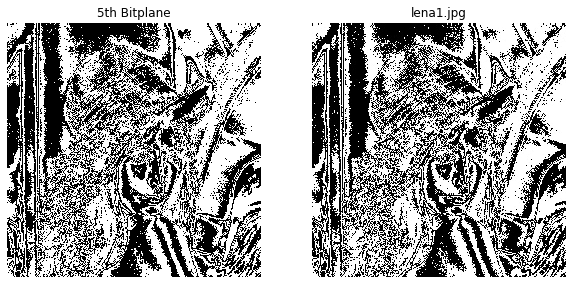

In [251]:
a = bitPlaneExtraction(img, Plot=False)
timg = a[5]
plot([timg, img1], gray=True, titles=["5th Bitplane", "lena1.jpg"], FigSize=(10,10))

### b) LENA2
The operation is ***quantisation to 2 bits***

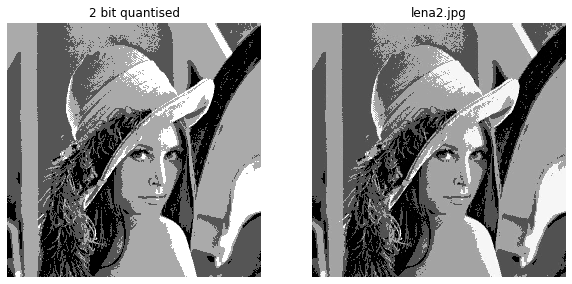

In [252]:
timg = BitQuantizeImage(img, 2, plot=False)
plot([timg, img2], gray=True, titles=["2 bit quantised", "lena2.jpg"], FigSize=(10,10))

### c) LENA3
The operation is ***extracting the 8th bitplane***.

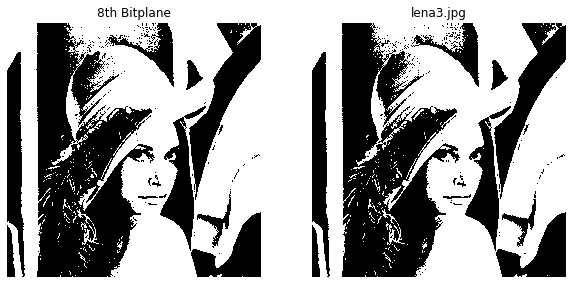

In [254]:
a = bitPlaneExtraction(img, Plot=False)
timg = a[8]
plot([timg, img3], gray=True, titles=["8th Bitplane", "lena3.jpg"], FigSize=(10,10))

---
<div width="100%" align="center"> <h1>Q4</h1></div>

---

## 1. Negative of an Image

In [256]:
img = read_img(root+"lena.jpg", gray=True)

In [269]:
def negativeImage(img, max_intensity, Plot=True):
    '''
    0 maps to L-1
    L-1 maps to 0
    L is the number of gray levels(max_intensity)
    '''
    
    img_dash = max_intensity-img.copy()
    if Plot: plot([img, img_dash], gray=True, FigSize=(10,10))
    return img_dash

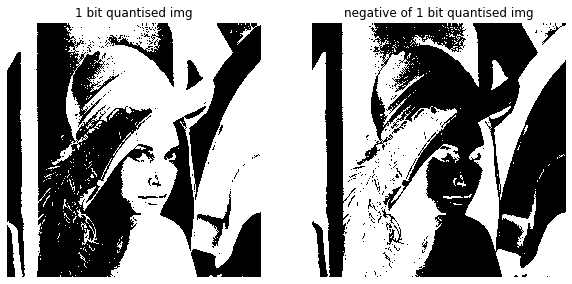

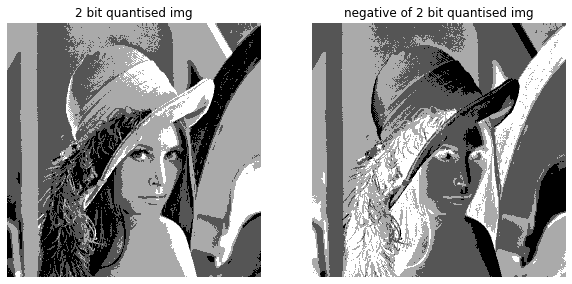

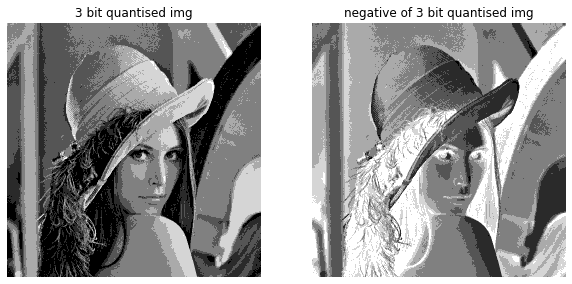

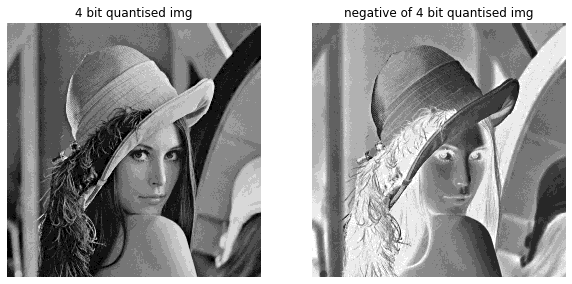

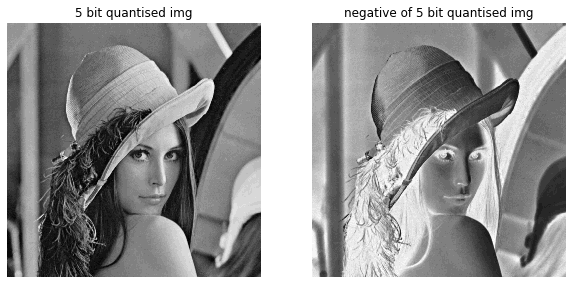

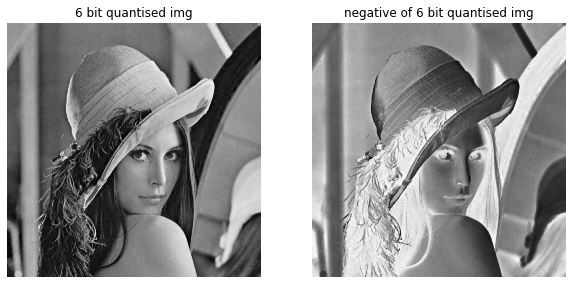

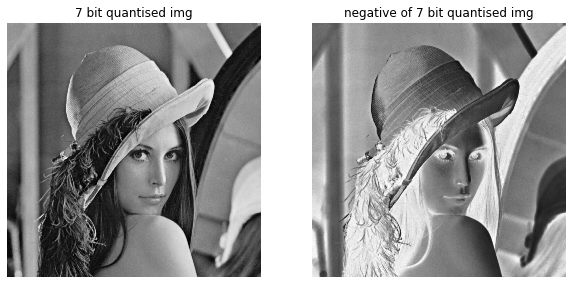

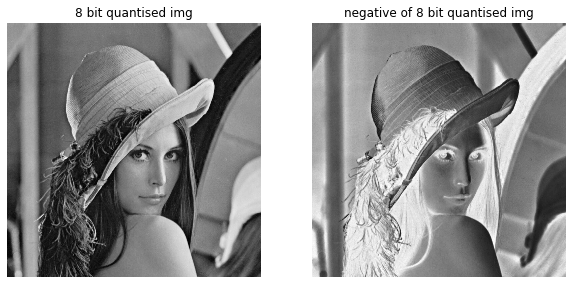

In [272]:
for i in range(1,9):
    timg = BitQuantizeImage(img, i, plot=False)
    neg_timg = negativeImage(timg, max_intensity=np.max(timg), Plot=False)
    
    labels = ["{} bit quantised img".format(i), "negative of {} bit quantised img".format(i)]
    plot([timg, neg_timg], gray=True, titles=labels, FigSize=(10,10))

## 2. Gamma Transform

1. This is an ***Interactive Slider for Gamma (y)***
2. **Observations**  
        a. A higher value of gamma(greater than 1) causes:-
            * The lighter gray levels quickly saturate. Hence many near white grey levels become exactly white.
            * The lower grey levels also go to a more lighter shade. 
            
        b. A lower value of gamma(lower than 1) causes:-
            * All the shades become darker.
            * The darker shades are mapped to fewer values than lighter shades. ie, there is more loss of
              details in the darker grey values.

In [278]:
img = read_img(root+'gamma-corr.png', gray=True)

In [291]:
@interact(img=fixed(img), y=(0.1,2, 0.1), Plot=fixed(True))
def gammaTransform(img, y, Plot=True):
    img = np.array(img, dtype=np.float64)
    timg = np.array(np.clip(np.power(img, y), 0, 255), dtype=np.uint8)
    if Plot: plot([img, timg], gray=True, titles=["original", "modified"], FigSize=(15,15))

interactive(children=(FloatSlider(value=1.0, description='y', max=2.0, min=0.1), Output()), _dom_classes=('wid…